In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import h5py

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 2] No such file or directory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


In [3]:
cd ..

/Share/home/shibinbin/projects/emaize


In [4]:
def generate_parent_table(phenotype_file):
    phenotypes = pd.read_table(phenotype_file)
    pedigree = phenotypes['pedigree'].str.split('_', expand=True)
    pedigree.columns = ['f', 'X', 'm']
    phenotypes = pd.concat([phenotypes, pedigree], axis=1)
    phenotypes['number'] = np.arange(phenotypes.shape[0])
    parent_table = phenotypes.pivot_table(values='number', index=['m'], columns=['f'], dropna=False)
    male_ids = ['m%d' % i for i in range(1, parent_table.shape[0] + 1)]
    female_ids = ['f%d' % i for i in range(1, parent_table.shape[1] + 1)]
    parent_table = parent_table.loc[male_ids, female_ids]
    return parent_table

In [5]:
parent_table = generate_parent_table('emaize_data/phenotype/pheno_emaize.txt')

In [6]:
parent_table.head()

f,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f198,f199,f200,f201,f202,f203,f204,f205,f206,f207
m,,,,,,,,,,,,,,,,,,,,,
m1,0,1,2,3,4,5,6,7,8,9,...,4762,4764,4756,4761,4763,5050,5051,5052,5053,5054
m2,191,192,193,195,196,197,198,199,200,201,...,333,379,4767,4768,4777,5055,5056,5057,5058,5059
m3,380,381,382,384,385,386,387,388,389,390,...,520,569,442,4786,4789,5060,5061,5062,5063,5064
m4,570,571,572,574,575,576,577,578,579,580,...,4797,4802,633,4796,4800,5065,5066,5067,5068,5069
m5,759,760,761,763,764,765,766,767,768,769,...,901,4814,4805,835,4813,5277,5278,5279,5280,5281


In [7]:
phenotypes = pd.read_table('emaize_data/phenotype/pheno_emaize.txt')

In [8]:
phenotypes.head()

,type,id,pedigree,trait1,trait2,trait3
0,training,L0001,f1_X_m1,-1.746103,-0.785525,-0.331637
1,training,L0002,f2_X_m1,-1.679248,-1.569490,-2.572614
2,training,L0003,f3_X_m1,-2.748920,-0.608644,-1.108812
3,training,L0004,f4_X_m1,-2.414647,-0.672045,-1.315051
4,training,L0005,f5_X_m1,-1.879812,-0.740913,-1.879181


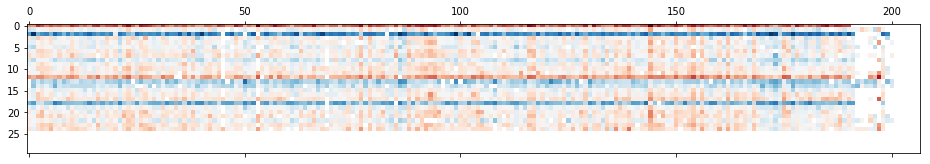

In [26]:
matshow(y['trait1'], cmap=cm.RdBu)

In [13]:
y = {}
for trait in ('trait1', 'trait2', 'trait3'):
    y[trait] = np.take(phenotypes[trait].values, parent_table)

In [35]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('tmp/phenotypes_heatmap.pdf') as pdf:
    for i in range(1, 4):
        plt.clf()
        fig, ax = plt.subplots(figsize=(18, 3))
        phenotype_matrix = np.take(np.ravel(phenotypes['trait%d'%i].values), parent_table)
        image = ax.matshow(phenotype_matrix, cmap=cm.RdBu_r)
        ax.set_title('Phenotypes of training data (trait%d)'%i)
        plt.colorbar(image)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)
        #np.savetxt(phenotype_matrix, )

In [34]:
ax.imshow?

In [32]:
y_female = {}
y_male = {}
for trait in y.keys():
    n_valid_male = np.sum(np.logical_not(np.isnan(y[trait])), axis=0)
    y_female[trait] = np.mean(nan_to_num(y[trait]), axis=0)/n_valid_male
    y_female[trait][-5:] = np.nan
    n_valid_female = np.sum(np.logical_not(np.isnan(y[trait])), axis=1)
    y_male[trait] = np.mean(nan_to_num(y[trait]), axis=1)/n_valid_female
    y_male[trait][-5:] = np.nan

/Share/home/shibinbin/apps/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/Share/home/shibinbin/apps/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


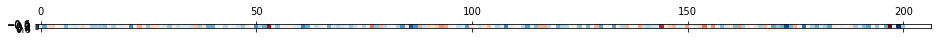

In [25]:
matshow(y_female['trait1'].reshape((1, -1)), cmap=cm.RdBu)

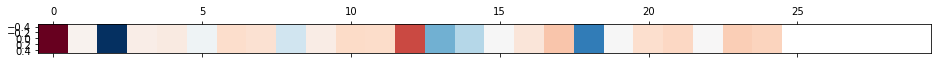

In [29]:
matshow(y_male['trait1'].reshape((1, -1)), cmap=cm.RdBu)

In [35]:
with h5py.File('data/phenotypes/parent', 'w') as f:
    g = f.create_group('female')
    for trait in y_female.keys():
        g.create_dataset(trait, data=y_female[trait])
    g = f.create_group('male')
    for trait in y_male.keys():
        g.create_dataset(trait, data=y_male[trait])

In [34]:
with h5py.File('tmp/parent_phenotypes_indices.h5', 'w') as f:
    f.create_dataset('female', data=np.nonzero(np.logical_not(np.isnan(y_female['trait1'])))[0])
    f.create_dataset('male', data=np.nonzero(np.logical_not(np.isnan(y_male['trait1'])))[0])